In [1]:
'''Reference: https://www.kaggle.com/gbellport/pneumonia-detection-96-recall-91-accuracy'''

# Importing all the necessary packages/libraries

import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt


import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

seed = 24
np.random.seed(seed)

Using TensorFlow backend.


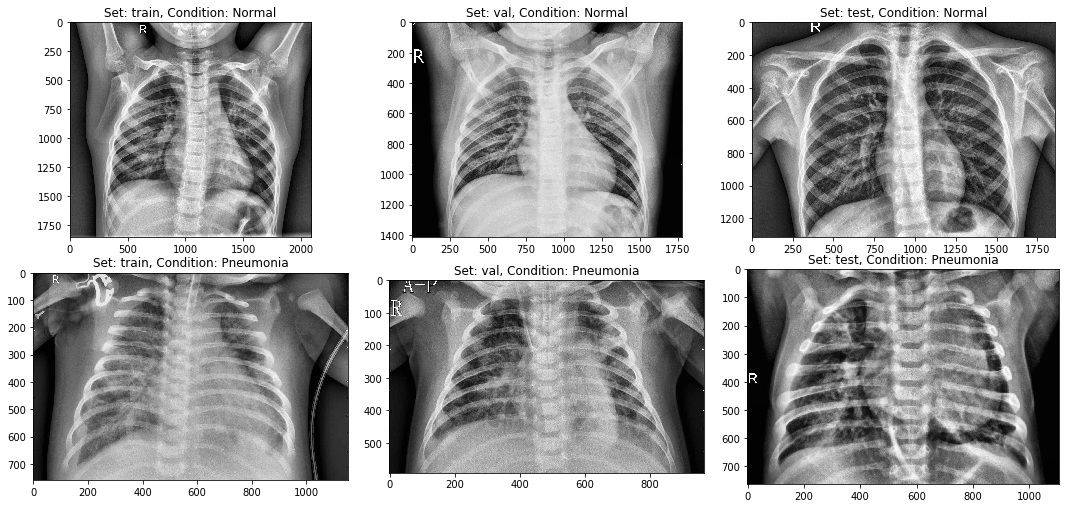

In [2]:
# Displaying pre-processed images

path = 'Processed-XRAY//chest_xray/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = path+_set
    
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))


In [4]:
# Image augmentation using ImageDataGenerator from KERAS


def process_data(img_dims, batch_size):

# creating objects of ImageDataGenerator class

    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
# Image augmentation using created objects

    train_gen = train_datagen.flow_from_directory(
    directory=path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
# Creating test arrays and labels to evaluate model performance using accuracy metrics

    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(path + 'test' + cond)):
            img = plt.imread(path+'test'+cond+img)
            
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
           
            img = img.astype('float32') / 255



            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels 

In [5]:
# Assigning hyperparameter values

img_dims = 150
epochs = 5
batch_size = 32

# Generating augmented data and test array, labels using 
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
# Applied CNN Architecture

# First layer - Input layer
inputs = Input(shape=(img_dims, img_dims, 3))

# Second layer - First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third layer - Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth layer - Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fifth layer - Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Sixth layer - Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Seventh layer - FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Eight layer - Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating and compiling model object

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')


In [7]:

# Model training using training dataset from data augmentation function

hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])


Epoch 1/5
163/163 [==============================] - 258s 2s/step - loss: 0.1108 - accuracy: 0.9586 - val_loss: 3.2237 - val_accuracy: 0.6234
Epoch 2/5
163/163 [==============================] - 247s 2s/step - loss: 0.0486 - accuracy: 0.9893 - val_loss: 1.9836 - val_accuracy: 0.6301
Epoch 3/5
163/163 [==============================] - 211s 1s/step - loss: 0.0446 - accuracy: 0.9896 - val_loss: 1.6716 - val_accuracy: 0.6166

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/5
163/163 [==============================] - 213s 1s/step - loss: 0.0290 - accuracy: 0.9933 - val_loss: 2.1369 - val_accuracy: 0.6334
Epoch 5/5
163/163 [==============================] - 210s 1s/step - loss: 0.0232 - accuracy: 0.9931 - val_loss: 0.8709 - val_accuracy: 0.7061

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.


In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Model prediction on test data
preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

# Model evaluation using accuracy metrics

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

CONFUSION MATRIX ------------------
[[ 51 183]
 [  6 384]]

TEST METRICS ----------------------
Accuracy: 69.71153846153845%
Precision: 67.72486772486772%
Recall: 98.46153846153847%
F1-score: 80.25078369905955
